## Import Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../Dataset/indo_population_1980-2022_cleaned.csv', parse_dates= ['year'])
df['year'] = df['year'].dt.year

print('Table Structure (Rows, Columns):', df.shape)
df.head()

Table Structure (Rows, Columns): (43, 5)


,year,productive_population,unproductive_population,dependency_ratio,total_population
0,1980,83555877,66765622,79.905357,150321499
1,1981,85684299,67780482,79.104903,153464781
2,1982,87831396,68788744,78.319083,156620140
3,1983,90051324,69731035,77.434769,159782359
4,1984,92426930,70512954,76.290486,162939884


From the Data above, it is showing Indonesia's Unproductive Population 1980 - 2022.  In the End We Will Forecast the result for 2023 - 2024

## Unproductive Age Growth Graph (1980 - 2022)

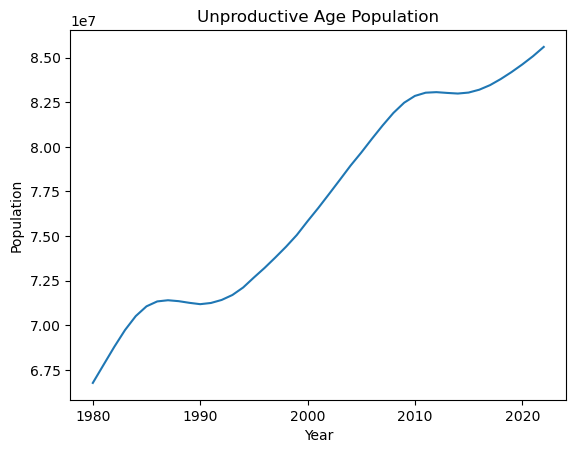

In [2]:
sns.lineplot(data=df, x='year', y='unproductive_population')
plt.title('Unproductive Age Population')
plt.xlabel('Year')
plt.ylabel('Population')

plt.show()

## Function to Show List of Difference and P-Value

In [3]:
from statsmodels.tsa.stattools import adfuller

def diff_count(df_col):
    results = {}
    data = df_col
    for i in range (1, 6):
        data = data.diff().dropna()
        adf = adfuller(data)
        p_value = adf[1]
        results[i] = p_value
    
    return results

## Check whether the Data is Stationary or Not

In [4]:
data = df['unproductive_population']

print(f'P-Value: {adfuller(data)[1]}')

P-Value: 0.9555978620425138


From the result above, data is not Stasionary because from ADF Test, Data P-Value should be below 0.05

## Check How Many Differentiate We Need in Order to Make Data Stasionary

In [5]:
diff_list = diff_count(data)

diff_list

{1: 0.0005278260742281612,
 2: 0.3354595363637376,
 3: 8.316936108484274e-07,
 4: 8.395941763587629e-22,
 5: 0.0002807143070587553}

From the list above, data will be stationary if we differentiate once, it will be ARIMA(p,1,q)

## Show Visualization of Stationary Data

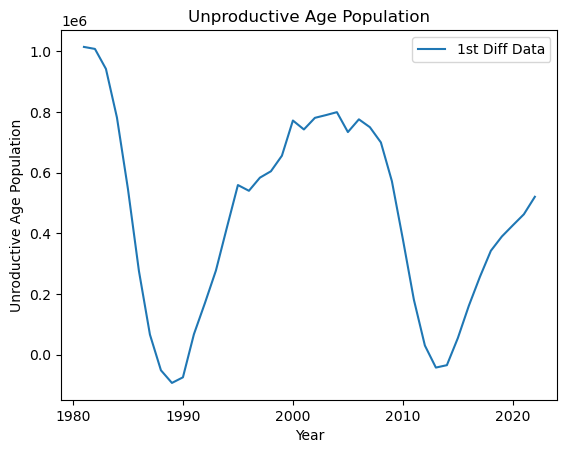

In [6]:
diff_data = data
for i in range(1):
    diff_data = diff_data.diff().dropna()
    
plt.plot(df['year'][1:], diff_data, linestyle='-', label='1st Diff Data')

plt.xlabel('Year')
plt.ylabel('Unroductive Age Population')
plt.title('Unproductive Age Population')
plt.legend()

plt.show()

## Identify The ACF and PACF Graph from Stationary Data

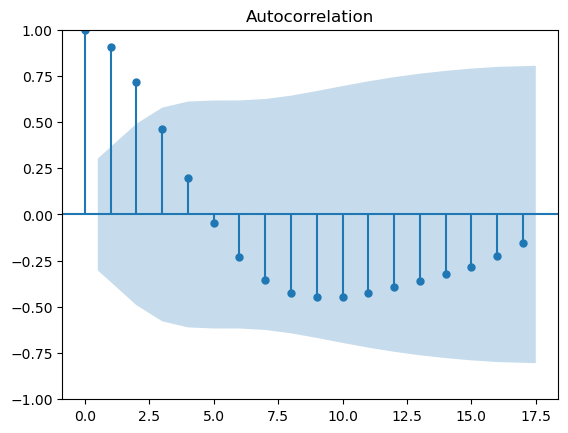

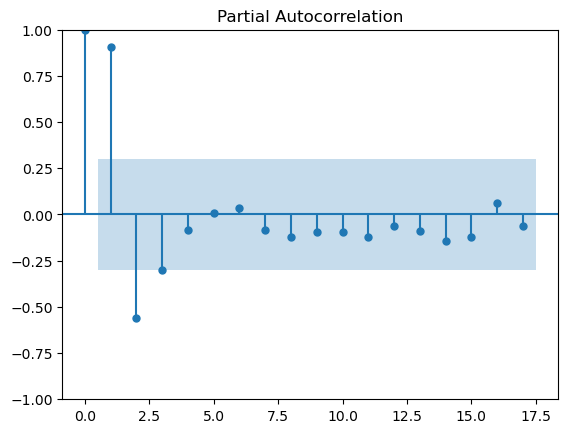

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_diff = plot_acf(diff_data)
pacf_diff = plot_pacf(diff_data)

From the graph above, we can conclude that HyperParameter p & q on ARIMA(p,2,q) will be p = 1, p = 2, or p = 3; and q = 1 or q = 2

## Determine the Optimal ARIMA Model

In [8]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import root_mean_squared_error
warnings.filterwarnings("ignore")

hyper_param = [(1,1,1), (1,1,2), (2,1,1), (2,1,2), (3,1,1), (3,1,2)]
for p,d,q in hyper_param:
    model = ARIMA(data, order=(p,d,q))
    pred = model.fit()
    rmse = root_mean_squared_error(data[d:], pred.fittedvalues[d:])
    print(f'RMSE Score for ARIMA({p},{d},{q}) {rmse}')

RMSE Score for ARIMA(1,1,1) 316258.2179468743
RMSE Score for ARIMA(1,1,2) 302719.24008686084
RMSE Score for ARIMA(2,1,1) 302507.1135820263
RMSE Score for ARIMA(2,1,2) 550234.6905863368
RMSE Score for ARIMA(3,1,1) 288795.33508251165
RMSE Score for ARIMA(3,1,2) 281525.4604213025


The optimal model is ARIMA(3,1,2)

## Forecast of Productive Age Population 2023-2024

In [9]:
model = ARIMA(data, order=(3,1,2))
pred = model.fit()

unproductive_population_forecast = pred.forecast(steps=2)

print("Forecasted Values:")
print(unproductive_population_forecast)

# From Google BiQuery
# 8.6168113e+07
# 8.6775015e+07

# From Linier Regression
# 8.705943e+07
# 8.752018e+07

Forecasted Values:
43    8.594284e+07
44    8.628075e+07
Name: predicted_mean, dtype: float64


## Adding Prediction Result Data to Data Frame

In [10]:
pred_res = pred.fittedvalues

df['unproductive_population_pred'] = pred_res

df.head()

,year,productive_population,unproductive_population,dependency_ratio,total_population,unproductive_population_pred
0,1980,83555877,66765622,79.905357,150321499,0.000000e+00
1,1981,85684299,67780482,79.104903,153464781,6.782460e+07
2,1982,87831396,68788744,78.319083,156620140,6.893790e+07
3,1983,90051324,69731035,77.434769,159782359,6.950981e+07
4,1984,92426930,70512954,76.290486,162939884,7.029307e+07


## Extracting Actual Data and Predicted Data from Data Frame

In [11]:
data = df[['year','unproductive_population']]
data_pred = df[['year','unproductive_population_pred']]

data.tail()

,year,unproductive_population
38,2018,83802362
39,2019,84191864
40,2020,84618324
41,2021,85081054
42,2022,85601547


In [12]:
data_pred.tail()

,year,unproductive_population_pred
38,2018,8.380474e+07
39,2019,8.414664e+07
40,2020,8.453551e+07
41,2021,8.496107e+07
42,2022,8.542286e+07


## Adding 2023 - 2024 Forecast Results to Prediction Data

In [13]:
new_rows = pd.DataFrame({
    'year': [2023, 2024],
    'unproductive_population_pred': unproductive_population_forecast
})

data_pred = pd.concat([data_pred, new_rows], ignore_index=True)

data_pred.tail()

,year,unproductive_population_pred
40,2020,8.453551e+07
41,2021,8.496107e+07
42,2022,8.542286e+07
43,2023,8.594284e+07
44,2024,8.628075e+07


## Visualization of Actual Data and Unproductive Age Prediction Data (1980 - 2024) Without Ignoring Differentiated Data

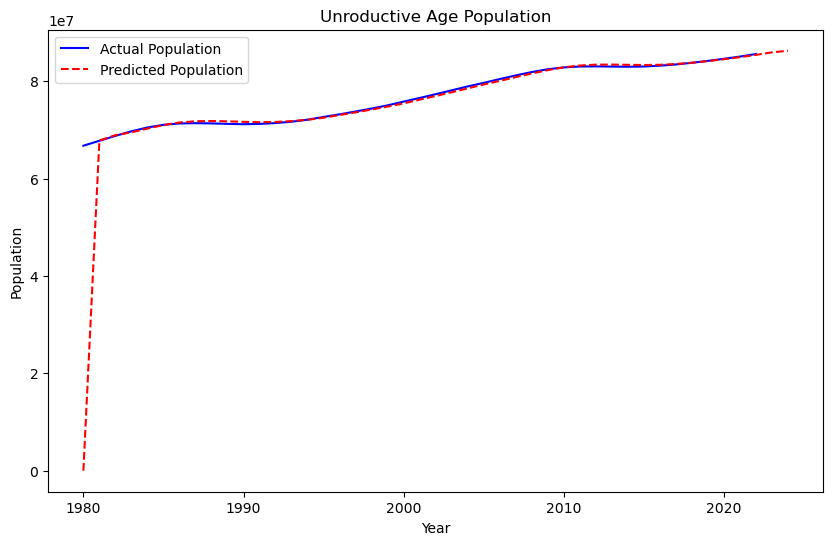

In [14]:
plt.figure(figsize=(10, 6))

plt.plot(data['year'], data['unproductive_population'], label='Actual Population', color='blue')
plt.plot(data_pred['year'], data_pred['unproductive_population_pred'], label='Predicted Population', color='red', linestyle='--')

plt.title('Unroductive Age Population')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.show()

## Visualization of Actual Data and Unproductive Age Prediction Data (1980 - 2024) With Ignoring Differentiated Data

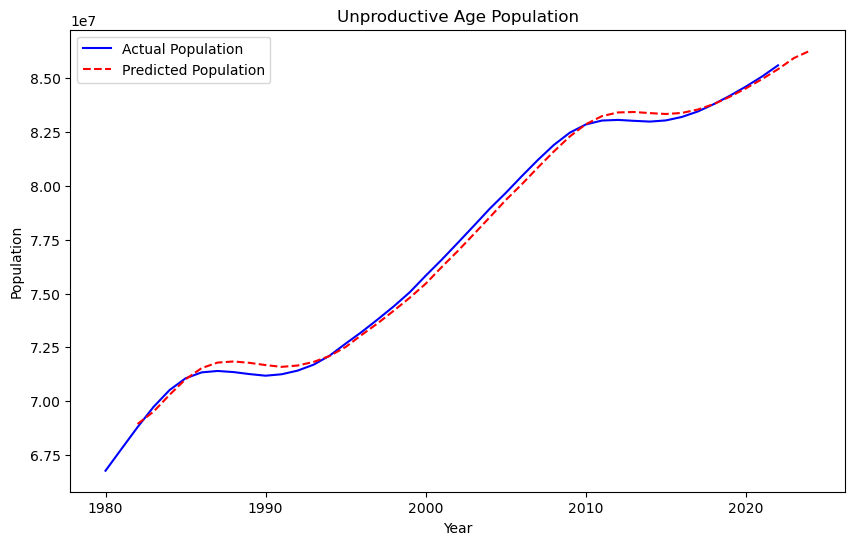

In [15]:
plt.figure(figsize=(10, 6))

plt.plot(data['year'], data['unproductive_population'], label='Actual Population', color='blue')
plt.plot(data_pred['year'][2:], data_pred['unproductive_population_pred'][2:], label='Predicted Population', color='red', linestyle='--')

plt.title('Unproductive Age Population')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.show()